In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import brentq, minimize
from scipy.stats import norm

# pd.set_option("display.max_rows", None)

In [2]:
end = datetime(2024, 3, 30)
options = pd.read_csv(r"data\cleaned_options_data.csv")


# Step 1: Convert the 'ts_recv' column to datetime (this is already optimized)
options["datetime"] = pd.to_datetime(options["ts_recv"], format="%Y-%m-%dT%H:%M:%S.%fZ")


# Step 2: Vectorized parsing of the 'symbol' column
# Split by spaces and extract the relevant parts directly
symbol_parts = options["symbol"].str.split(" ", expand=True)[1]


# Extract expiration date (first 6 characters)
options["exp_date"] = pd.to_datetime(symbol_parts.str[:6], format="%y%m%d")
options = options[options["exp_date"] <= end]


# Extract action ('C' or 'P', at index 6)
options["action"] = symbol_parts.str[6]


# Extract strike price (from index 7 onward, divided by 1000)
options["strike_price"] = symbol_parts.str[7:].astype(float) / 1000


# Step 3: Rename the other columns as needed
options = options.rename(
    columns={
        "bid_px_00": "bidp",
        "ask_px_00": "askp",
        "bid_sz_00": "bid_sz",
        "ask_sz_00": "ask_sz",
    }
)

options["datetime"] = (
    pd.to_datetime(options["datetime"])
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
    .dt.tz_localize(None)
)
options["date"] = options["datetime"].dt.date


# Calculate 'till_exp' (time to expiration in years)
options["till_exp"] = (options["exp_date"] - options["datetime"]).dt.days / 365.0


# Calculate 'fair_value' as the average of bid and ask price
options["fair_value"] = (options["bidp"] + options["askp"]) / 2.0

In [3]:
underlying = pd.read_csv(r"data\spx_minute_level_data_jan_mar_2024.csv")
underlying = underlying.loc[underlying["price"] > 0]
underlying["date"] = pd.to_datetime(underlying["date"], format="%Y%m%d")
underlying_min = underlying.copy()

underlying = (
    underlying.groupby("date")
    .agg(
        Open=("price", "first"),
        High=("price", "max"),
        Low=("price", "min"),
        Close=("price", "last"),
    )
    .reset_index()
)

In [4]:
underlying_min["date"] = pd.to_datetime(underlying_min["date"]).dt.date
time_part = pd.to_timedelta(underlying_min["ms_of_day"], unit="ms")
underlying_min["hour"] = time_part.dt.components.hours
underlying_min["minute"] = time_part.dt.components.minutes

In [5]:
indices = underlying["date"].searchsorted(options["datetime"]) - 1
indices = indices.clip(0, len(underlying) - 1)
options["underlying"] = underlying["Close"].iloc[indices].values

In [6]:
# options[options["date"] == datetime(2024, 3, 14).date()]

In [7]:
# underlying.tail(30)

In [8]:
# For calls, I want difference to be as high as possible
# For puts, I want difference to be as negative as possible
options["deviate"] = options["underlying"] - options["strike_price"]

# Make options["deviate"] negative for calls
options.loc[options["action"] == "P", "deviate"] *= -1

In [9]:
options.head(3)

,ts_recv,instrument_id,bidp,askp,bid_sz,ask_sz,symbol,datetime,exp_date,action,strike_price,date,till_exp,fair_value,underlying,deviate
0,2024-01-02T14:30:02.402838204Z,587228771,27.0,27.70,174,155,SPX 240119P04700000,2024-01-02 09:30:02.402838204,2024-01-19,P,4700.0,2024-01-02,0.043836,27.350,4743.14,-43.14
1,2024-01-02T14:30:02.402844171Z,587211744,1.6,1.75,755,1981,SPX 240119P04300000,2024-01-02 09:30:02.402844171,2024-01-19,P,4300.0,2024-01-02,0.043836,1.675,4743.14,-443.14
2,2024-01-02T14:30:02.402848382Z,587211728,4.1,4.40,1566,1125,SPX 240119P04500000,2024-01-02 09:30:02.402848382,2024-01-19,P,4500.0,2024-01-02,0.043836,4.250,4743.14,-243.14


In [10]:
# Create a loop over unique expiration dates
unique_exp_dates = options["exp_date"].unique()

# Results dictionary to store sorted options for each expiration date
results = {}
capital = 100_000_000
spend_lim_ratio = 0.9
threshold = 20
orders = pd.DataFrame(columns=["datetime", "option_symbol", "action", "order_size"])


for exp_date in unique_exp_dates:
    active_ord = pd.DataFrame(
        columns=[
            "strike_price",
            "order_size",
            "datetime",
            "exp_date",
            "action",
        ]
    )
    spend_limit = capital * spend_lim_ratio
    day_before_exp = (exp_date - pd.Timedelta(days=1)).date()
    filtered_options = options[
        (options["date"] == day_before_exp) & (options["exp_date"] == exp_date)
    ]
    filtered_options["sort_by"] = filtered_options["deviate"] - filtered_options["askp"]
    sorted_options = filtered_options.sort_values(by="sort_by", ascending=False)
    opp_options = filtered_options.sort_values(by="sort_by", ascending=True)
    # print(
    #     sorted_options[
    #         ["sort_by", "strike_price", "underlying", "date", "exp_date", "action"]
    #     ].head(5)
    # )
    print(
        opp_options[
            [
                "sort_by",
                "strike_price",
                "underlying",
                "date",
                "exp_date",
                "action",
                "bidp",
                "bid_sz",
            ]
        ].head(5)
    )

    # Loop through sorted options, keep buying the minimum between spend limit remaining and the ask size, break if sort_by < threshold
    for index, option in sorted_options.iterrows():
        # General stuff
        if option["sort_by"] < threshold:
            break
        if option["ask_sz"] == 0:
            continue
        order_size = min(
            (capital - spend_limit) / (option["askp"] * 100), option["ask_sz"]
        )
        if order_size <= 0:
            break
        options_cost = order_size * 100 * option["askp"]
        capital -= options_cost + 0.5

        new_row = pd.DataFrame(
            [
                {
                    "datetime": option["ts_recv"],  # ts_recv for the Call option
                    "option_symbol": option["symbol"],  # Use the Call option symbol
                    "action": "B",  # Action for the Call option
                    "order_size": order_size,  # Minimum ask size
                }
            ]
        )
        new_row2 = pd.DataFrame(
            [
                {
                    "strike_price": option["strike_price"],
                    "order_size": order_size,
                    "datetime": option["datetime"],
                    "exp_date": option["exp_date"],
                    "action": option["action"],
                }
            ]
        )
        orders = pd.concat(
            [orders, new_row],
            ignore_index=True,
        )
        active_ord = pd.concat(
            [active_ord, new_row2],
            ignore_index=True,
        )

    # Loop through active orders on expiration date and figure out prices
    active_ord["date"] = pd.to_datetime(active_ord["exp_date"]).dt.date

    # Create hour and minute columns but force them between 9:31 and 16:00
    active_ord["datetime"] = pd.to_datetime(active_ord["datetime"])
    active_ord["hour"] = active_ord["datetime"].dt.hour
    active_ord["minute"] = active_ord["datetime"].dt.minute
    active_ord.loc[(active_ord["hour"] < 9), "hour"] = 9
    active_ord.loc[
        (active_ord["hour"] == 9) & (active_ord["minute"] < 31), ["hour", "minute"]
    ] = [9, 31]
    active_ord.loc[(active_ord["hour"] > 16), ["hour", "minute"]] = [16, 0]

    # Merge with underlying_min to get the underlying price
    active_ord = active_ord.merge(
        underlying_min, how="left", on=["date", "hour", "minute"]
    )
    # print(active_ord.head(5))
    # break
    for index, option in active_ord.iterrows():
        diff = option["price"] - option["strike_price"]
        if option["action"] == "C":
            if diff > 0:
                capital += option["order_size"] * 100 * diff
        else:
            if diff < 0:
                capital += option["order_size"] * 100 * -diff
    print(capital)

# If you want to work further with `results`, you now have a dictionary
# where the keys are expiration dates and the values are the sorted DataFrames.

C:\Users\EricS\AppData\Local\Temp\ipykernel_29304\929237841.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_options["sort_by"] = filtered_options["deviate"] - filtered_options["askp"]


        sort_by  strike_price  underlying        date   exp_date action  bidp  \
331878  -775.88        4005.0     4780.78  2024-01-18 2024-01-19      P  0.05   
331454  -755.88        4025.0     4780.78  2024-01-18 2024-01-19      P  0.05   
331316  -745.88        4035.0     4780.78  2024-01-18 2024-01-19      P  0.05   
331304  -745.88        4035.0     4780.78  2024-01-18 2024-01-19      P  0.05   
331118  -725.88        4055.0     4780.78  2024-01-18 2024-01-19      P  0.05   

        bid_sz  
331878      10  
331454     392  
331316     216  
331304     387  
331118     654  
109125308.99608591


C:\Users\EricS\AppData\Local\Temp\ipykernel_29304\929237841.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_options["sort_by"] = filtered_options["deviate"] - filtered_options["askp"]


        sort_by  strike_price  underlying        date   exp_date action  bidp  \
887365  -830.38        4200.0     5030.28  2024-02-15 2024-02-16      P  0.05   
887388  -830.38        4200.0     5030.28  2024-02-15 2024-02-16      P  0.05   
887387  -830.38        4200.0     5030.28  2024-02-15 2024-02-16      P  0.05   
887338  -830.38        4200.0     5030.28  2024-02-15 2024-02-16      P  0.05   
887332  -830.38        4200.0     5030.28  2024-02-15 2024-02-16      P  0.05   

        bid_sz  
887365     138  
887388     126  
887387     130  
887338     148  
887332     175  
110026786.09302814


C:\Users\EricS\AppData\Local\Temp\ipykernel_29304\929237841.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_options["sort_by"] = filtered_options["deviate"] - filtered_options["askp"]


         sort_by  strike_price  underlying        date   exp_date action  \
1390169 -1011.62        4140.0     5151.52  2024-03-14 2024-03-15      P   
1390168 -1011.62        4140.0     5151.52  2024-03-14 2024-03-15      P   
1390146 -1011.62        4140.0     5151.52  2024-03-14 2024-03-15      P   
1390128 -1001.62        4150.0     5151.52  2024-03-14 2024-03-15      P   
1390069  -981.62        4170.0     5151.52  2024-03-14 2024-03-15      P   

         bidp  bid_sz  
1390169  0.05      24  
1390168  0.05      24  
1390146  0.05      44  
1390128  0.05      74  
1390069  0.05      29  
109751512.05639759


In [11]:
# underlying_min_test = underlying_min.copy()

# underlying_min_test[
#     (underlying_min_test["date"] == pd.Timestamp("2024-01-19").date())
#     & (underlying_min_test["hour"] == 13)
# ]

# Backtesting Code


In [12]:
from datetime import datetime
from backtester import Backtester
from feed_strategy import Strategy

start = datetime(2024, 1, 1)
end = datetime(2024, 3, 30)
s = Strategy(orders)
b = Backtester(start, end, s)

In [13]:
b.calculate_pnl()

2024-01-02 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-03 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-04 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-05 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-06 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-07 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-08 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-09 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-10 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-11 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-12 00:00:00 capital: 100000000 portfolio value: 0 to

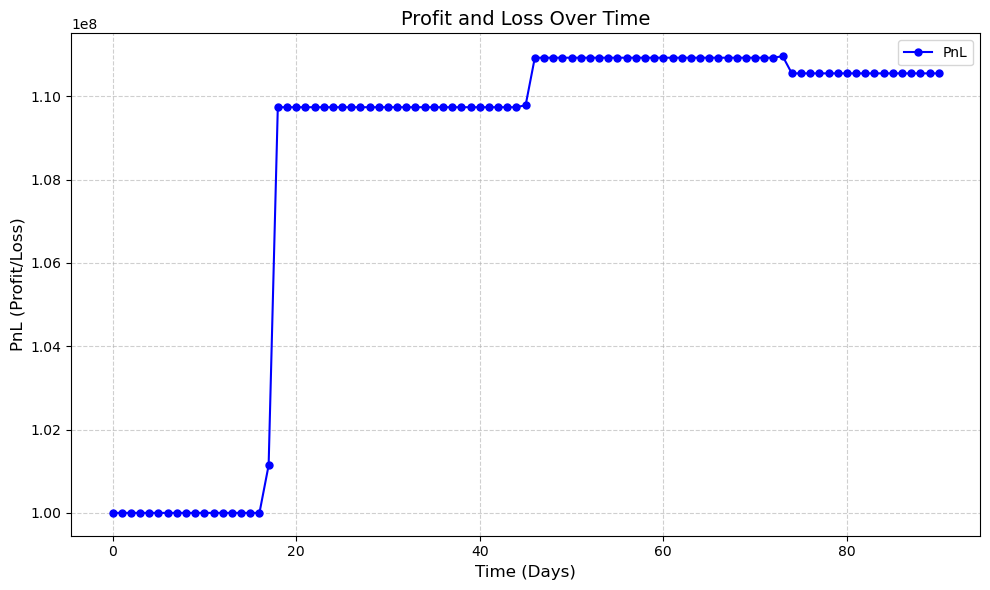

In [14]:
b.plot_pnl()

In [15]:
b.compute_overall_score()

Max Drawdown: 0.0037194968959961
Overall Return: 110.54843638230409%
Sharpe Ratio: 54.87977937327146
Overall Score: 1631100.6483838577
